In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
import collections

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_privacy as tfp
import platform
import time

In [ ]:
# download the keras dataset
(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# normalization
x=tf.image.per_image_standardization(x)
x_test=tf.image.per_image_standardization(x_test)


In [ ]:
# # convert the dataset to emnist dataset
NUM_CLIENTS = 200
total_image_count = len(x)
image_per_set = int(np.floor(total_image_count/NUM_CLIENTS))
client_train_dataset = collections.OrderedDict()
client_test_dataset = collections.OrderedDict()
for i in range(1, NUM_CLIENTS+1):
    client_name = "client_" + str(i)
    start = image_per_set * (i-1)
    end = image_per_set * i
    data = collections.OrderedDict((('label', y[start:end]), ('pixels', x[start:end])))
    client_train_dataset[client_name] = data
print("train set done.")
  
for i in range(1, NUM_CLIENTS+1):
    client_name = "client_" + str(i)
    start = image_per_set * (i-1)
    end = image_per_set * i
    data = collections.OrderedDict((('label', y_test[start:end]), ('pixels', x_test[start:end])))
    client_test_dataset[client_name] = data
print("test set done.")

emnist_train = tff.simulation.datasets.TestClientData(client_train_dataset)
emnist_test=tff.simulation.datasets.TestClientData(client_test_dataset)

train set done.
test set done.


In [ ]:
NUM_ROUNDS = 100
NUM_EPOCHS = 5
BATCH_SIZE = 16
SHUFFLE_BUFFER = 418
PREFETCH_BUFFER = 10
CLIENTS_PER_THREAD=2
server_lr=1.0
client_lr=0.01

# preprocess the dataset
def get_emnist_dataset(emnist_train, emnist_test):
  def batch_format_fn(element):
    return collections.OrderedDict(
        x=tf.expand_dims(element['pixels'], -1), y=element['label'])

  def preprocess_train_dataset(dataset):
    return dataset.map(batch_format_fn).repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).prefetch(PREFETCH_BUFFER)

  def preprocess_test_dataset(dataset):
    return dataset.map(batch_format_fn).batch(128, drop_remainder=False)

  emnist_train = emnist_train.preprocess(preprocess_train_dataset)
  emnist_test = preprocess_test_dataset(
      emnist_test.create_tf_dataset_from_all_clients())
  
  return emnist_train, emnist_test

train_data, test_data = get_emnist_dataset(emnist_train, emnist_test)

In [ ]:
# define the model
def create_keras_model():
  
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(10))
  return model
  
def model_fn():
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
    input_spec=test_data.element_spec ,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Determine the noise sensitivity of the model
# Run five clients per thread. Increase this if your runtime is running out of
# memory. Decrease it if you have the resources and want to speed up execution.
tff.backends.native.set_local_execution_context(CLIENTS_PER_THREAD)

total_clients = len(train_data.client_ids)
print(total_clients)

def train(rounds, noise_multiplier, clients_per_round, data_frame):
  # Using the `dp_aggregator` here turns on differential privacy with adaptive
  # clipping.
  aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
      noise_multiplier, clients_per_round)

  # We use Poisson subsampling which gives slightly tighter privacy guarantees
  # compared to having a fixed number of clients per round. The actual number of
  # clients per round is stochastic with mean clients_per_round.
  sampling_prob = clients_per_round / total_clients

  # Build a federated averaging process.
  # Typically a non-adaptive server optimizer is used because the noise in the
  # updates can cause the second moment accumulators to become very large
  # prematurely.
  learning_process = tff.learning.build_federated_averaging_process(
        model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(client_lr),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(server_lr, momentum=0.9),
        model_update_aggregation_factory=aggregation_factory)

  eval_process = tff.learning.build_federated_evaluation(model_fn)

  # Training loop.
  start_time = time.time()
  state = learning_process.initialize()
  for round in range(rounds):
    # if round % 5 == 0:
    metrics = eval_process(state.model, [test_data])['eval']
  # if round < 25 or round % 25 == 0:
    print(f'Round {round:3d}: {metrics}')
    data_frame = data_frame.append({'Round': round,
                                      'NoiseMultiplier': noise_multiplier,
                                      **metrics}, ignore_index=True)

    # Sample clients for a round. Note that if your dataset is large and
    # sampling_prob is small, it would be faster to use gap sampling.
    x = np.random.uniform(size=total_clients)
    # sampled_clients = np.random.choice(
    #     emnist_train.client_ids,
    #     size=CLIENTS_PER_ROUND,
    #     replace=False)
    # sampled_train_data = [
    # preprocess(emnist_train.create_tf_dataset_for_client(x))

    sampled_clients = [
        train_data.client_ids[i] for i in range(1, total_clients)
        if x[i] < sampling_prob]
    sampled_train_data = [
        train_data.create_tf_dataset_for_client(client)
        for client in sampled_clients]

    # Use selected clients for update.
    state, metrics = learning_process.next(state, sampled_train_data)

  metrics = eval_process(state.model, [test_data])['eval']
  print(f'Round {rounds:3d}: {metrics}')
  data_frame = data_frame.append({'Round': rounds,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)

  return data_frame


200


In [ ]:
data_frame = pd.DataFrame()
rounds = 10
clients_per_round = 20

for noise_multiplier in [0.0, 0.5, 0.75, 1.0]:
  print(f'Starting training with noise multiplier: {noise_multiplier}')
  data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)
  print()

Starting training with noise multiplier: 0.0
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.0829), ('loss', 2.351136)])
Round   1: OrderedDict([('sparse_categorical_accuracy', 0.1028), ('loss', 2.3067575)])
Round   2: OrderedDict([('sparse_categorical_accuracy', 0.1408), ('loss', 2.1792116)])
Round   3: OrderedDict([('sparse_categorical_accuracy', 0.4252), ('loss', 1.8734308)])
Round   4: OrderedDict([('sparse_categorical_accuracy', 0.7456), ('loss', 1.3100146)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.8297), ('loss', 0.69860774)])
Round   6: OrderedDict([('sparse_categorical_accuracy', 0.8361), ('loss', 0.5194015)])
Round   7: OrderedDict([('sparse_categorical_accuracy', 0.8365), ('loss', 0.62539744)])
Round   8: OrderedDict([('sparse_categorical_accuracy', 0.8568), ('loss', 0.65978795)])
Round   9: OrderedDict([('sparse_categorical_accuracy', 0.8872), ('loss', 0.542817)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.91), ('loss', 0.34821528)])

Starting training with noise multiplier: 0

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_plot(data_frame):
  plt.figure(figsize=(15, 5))

  dff = data_frame.rename(
      columns={'sparse_categorical_accuracy': 'Accuracy', 'loss': 'Loss'})

  plt.subplot(121)
  sns.lineplot(data=dff, x='Round', y='Accuracy', hue='NoiseMultiplier', palette='dark')
  plt.subplot(122)
  sns.lineplot(data=dff, x='Round', y='Loss', hue='NoiseMultiplier', palette='dark')

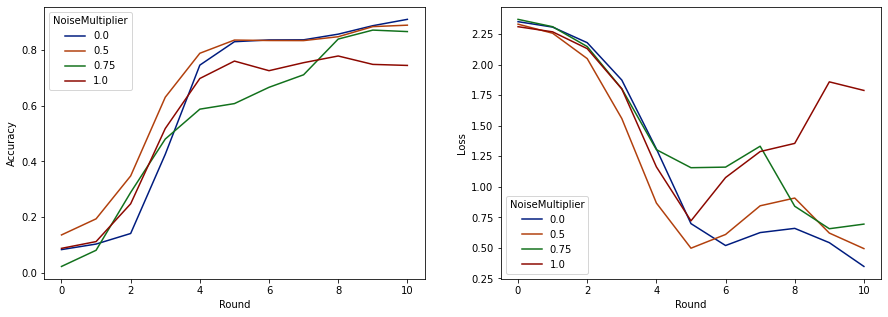

In [ ]:
make_plot(data_frame)

In [ ]:
rdp_orders = ([1.25, 1.5, 1.75, 2., 2.25, 2.5, 3., 3.5, 4., 4.5] +
              list(range(5, 64)) + [128, 256, 512])
total_clients = 200
base_noise_multiplier = 0.75
base_clients_per_round = 20
target_delta = 1e-5
target_eps = 2

def get_epsilon(clients_per_round):
  # If we use this number of clients per round and proportionally
  # scale up the noise multiplier, what epsilon do we achieve?
  q = clients_per_round / total_clients
  noise_multiplier = base_noise_multiplier
  noise_multiplier *= clients_per_round / base_clients_per_round
  rdp = tfp.compute_rdp(
      q, noise_multiplier=noise_multiplier, steps=rounds, orders=rdp_orders)
  eps, _, _ = tfp.get_privacy_spent(rdp_orders, rdp, target_delta=target_delta)
  return clients_per_round, eps, noise_multiplier

def find_needed_clients_per_round():
  hi = get_epsilon(base_clients_per_round)
  if hi[1] < target_eps:
    return hi

  # Grow interval exponentially until target_eps is exceeded.
  while True:
    lo = hi
    hi = get_epsilon(2 * lo[0])
    if hi[1] < target_eps:
      break

  # Binary search.
  while hi[0] - lo[0] > 1:
    mid = get_epsilon((lo[0] + hi[0]) // 2)
    if mid[1] > target_eps:
      lo = mid
    else:
      hi = mid

  return hi

clients_per_round, _, noise_multiplier = find_needed_clients_per_round()
print(f'To get ({target_eps}, {target_delta})-DP, use {clients_per_round} '
      f'clients with noise multiplier {noise_multiplier}.')

To get (2, 1e-05)-DP, use 97 clients with noise multiplier 3.6374999999999997.


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.1012), ('loss', 2.3148072)])
Round   1: OrderedDict([('sparse_categorical_accuracy', 0.1276), ('loss', 2.2748575)])
Round   2: OrderedDict([('sparse_categorical_accuracy', 0.2832), ('loss', 2.1527731)])
Round   3: OrderedDict([('sparse_categorical_accuracy', 0.5138), ('loss', 1.8307264)])
Round   4: OrderedDict([('sparse_categorical_accuracy', 0.649), ('loss', 1.2930434)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.7648), ('loss', 0.73647004)])
Round   6: OrderedDict([('sparse_categorical_accuracy', 0.8194), ('loss', 0.58174044)])
Round   7: OrderedDict([('sparse_categorical_accuracy', 0.7887), ('loss', 0.9195627)])
Round   8: OrderedDict([('sparse_categorical_accuracy', 0.8081), ('loss', 1.0768452)])
Round   9: OrderedDict([('sparse_categorical_accuracy', 0.8554), ('loss', 0.8285288)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.8788), ('loss', 0.6446056)])


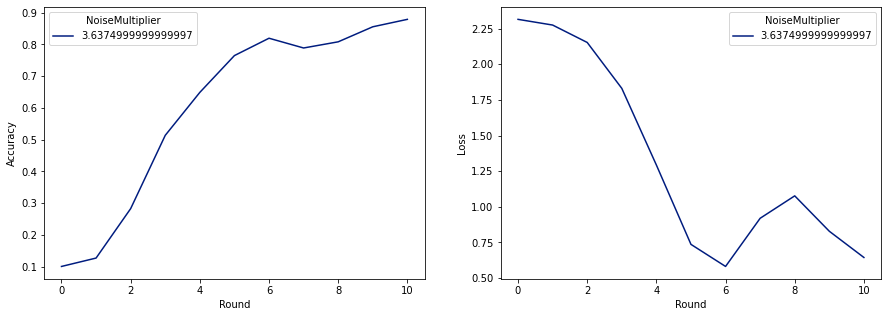

In [ ]:
rounds = 10
noise_multiplier = 3.6374999999999997
clients_per_round = 97

data_frame = pd.DataFrame()
data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)

make_plot(data_frame)